In [2]:
import pandas as pd
import numpy as np
from safegraph_py_functions import safegraph_py_functions as sgpy
import os
from dotenv import load_dotenv, find_dotenv
from loguru import logger

In [3]:
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)
os.chdir(os.environ.get("ROOT_DIR"))
from src import DATA_DIR


In [4]:
clusters = pd.read_csv(DATA_DIR / 'processed' / 'sg_clusters.csv')

In [5]:
places = pd.read_csv(DATA_DIR / 'processed' / 'philly_places.csv.tar.gz', low_memory = False)

In [6]:
places = places.sort_values('valid_from', ascending = False)

In [7]:
places.valid_from.unique()

array(['2020-09-08', '2020-08-07', '2020-07-13', '2020-06-06',
       '2020-05-06', '2020-04-07', '2020-03-25', '1900-01-01'],
      dtype=object)

In [8]:
places = places.groupby('safegraph_place_id').first().reset_index()

In [9]:
places.groupby('valid_from').size()

valid_from
1900-01-01       95
2020-03-25      512
2020-04-07       68
2020-05-06      192
2020-06-06     3050
2020-07-13      599
2020-08-07      224
2020-09-08    21076
dtype: int64

In [10]:
places.head()

,safegraph_place_id,parent_safegraph_place_id,location_name,safegraph_brand_ids,brands,top_category,sub_category,naics_code,latitude,longitude,...,phone_number,open_hours,category_tags,valid_to,valid_from,placekey,opened_on,closed_on,tracking_opened_since,tracking_closed_since
0,sg:0000395ed3954bf6bce9fc48d52f3c5b,None,Lanci Bakery,None,None,Bakeries and Tortilla Manufacturing,Retail Bakeries,311811.0,39.923647,-75.175465,...,1.215463e+10,None,None,2020-07-13,2020-06-06,None,None,2020-01,None,2019-07
1,sg:00018e7b1ba449278dd1c33a2348e5fa,None,Maxi Gastronome,None,None,Restaurants and Other Eating Places,Full-Service Restaurants,722511.0,40.106492,-75.029052,...,NaN,"{ ""Mon"": [[""9:00"", ""20:00""]], ""Tue"": [[""9:00"",...","Russian Food,European Food",2020-10-19,2020-09-08,225-222@628-p9p-tgk,None,None,None,2019-07
2,sg:0001da921b9d488986c0bdf83bfaff4b,None,Carlo's Tire & Repairs,None,None,"Automotive Parts, Accessories, and Tire Stores",Automotive Parts and Accessories Stores,441310.0,40.102114,-75.031340,...,1.215465e+10,"{ ""Mon"": [[""8:00"", ""17:00""]], ""Tue"": [[""8:00"",...",None,2020-10-19,2020-09-08,zzw-223@628-p9p-qmk,None,None,None,2019-07
3,sg:0003e5a379604393b0dc6e9bce0058b2,sg:e61ba782d68d41f58ea5ef4cdde0565b,Little Caesars,SG_BRAND_3654ed70612445d52bf3b6f6546d1f23,Little Caesars,Restaurants and Other Eating Places,Limited-Service Restaurants,722513.0,39.982305,-75.239359,...,1.215878e+10,None,"Counter Service,Pizza,Lunch,Fast Food,Dinner",2020-10-19,2020-09-08,222-222@628-ph5-qcq,None,None,2020-01,2019-07
4,sg:0004189674c64e108e4b5ea2baa68eb9,None,Popeyes Louisiana Kitchen,SG_BRAND_5725c57624e4d885d0bf718123615aa9,Popeyes Louisiana Kitchen,Restaurants and Other Eating Places,Limited-Service Restaurants,722513.0,39.924732,-75.169153,...,1.215334e+10,None,"Fried Chicken,Fast Food,Lunch,Dinner",2020-10-19,2020-09-08,227-222@628-pm4-gtv,None,None,None,2019-07


In [11]:
clusters.head()

,safegraph_place_id,cluster
0,sg:00018e7b1ba449278dd1c33a2348e5fa,1
1,sg:0001da921b9d488986c0bdf83bfaff4b,1
2,sg:0003e5a379604393b0dc6e9bce0058b2,5
3,sg:0004189674c64e108e4b5ea2baa68eb9,1
4,sg:0008547f38f54091836959120205256c,10


In [12]:
clusters = clusters.merge(places, on ='safegraph_place_id')

### Convert to geo df

In [28]:
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import hvplot.pandas
import geopandas as gpd
import urllib.request
import json
from matplotlib import pyplot as plt


In [17]:
clusters = clusters.dropna(subset=['latitude', 'longitude'])

In [19]:
clusters['Coordinates'] = list(zip(clusters['longitude'], clusters['latitude']))

In [20]:
clusters['Coordinates'].head()

0    (-75.029052, 40.106492)
1     (-75.03134, 40.102114)
2    (-75.239359, 39.982305)
3    (-75.169153, 39.924732)
4    (-75.141649, 39.974429)
Name: Coordinates, dtype: object

In [21]:
from shapely.geometry import Point
clusters['Coordinates'] = clusters['Coordinates'].apply(Point)

In [22]:
clusters = gpd.GeoDataFrame(clusters, geometry="Coordinates", crs={"init": "epsg:4326"})

//anaconda3/envs/safegraph/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [23]:
clusters = clusters.to_crs(epsg=3857)

In [25]:
city_limits = gpd.read_file(DATA_DIR / 'raw' / 'City_Limits')
city_limits = city_limits.to_crs(epsg=3857)

In [35]:
clusters = gpd.sjoin(clusters, city_limits, op='within')


In [36]:
import contextily as ctx

In [37]:
clusters.head()

,safegraph_place_id,cluster,parent_safegraph_place_id,location_name,safegraph_brand_ids,brands,top_category,sub_category,naics_code,latitude,...,placekey,opened_on,closed_on,tracking_opened_since,tracking_closed_since,Coordinates,index_right,OBJECTID,Shape__Are,Shape__Len
0,sg:00018e7b1ba449278dd1c33a2348e5fa,1,None,Maxi Gastronome,None,None,Restaurants and Other Eating Places,Full-Service Restaurants,722511.0,40.106492,...,225-222@628-p9p-tgk,None,None,None,2019-07,POINT (-8352195.863 4881429.496),0,1,0.038911,1.259687
1,sg:0001da921b9d488986c0bdf83bfaff4b,1,None,Carlo's Tire & Repairs,None,None,"Automotive Parts, Accessories, and Tire Stores",Automotive Parts and Accessories Stores,441310.0,40.102114,...,zzw-223@628-p9p-qmk,None,None,None,2019-07,POINT (-8352450.562 4880792.322),0,1,0.038911,1.259687
2,sg:0003e5a379604393b0dc6e9bce0058b2,5,sg:e61ba782d68d41f58ea5ef4cdde0565b,Little Caesars,SG_BRAND_3654ed70612445d52bf3b6f6546d1f23,Little Caesars,Restaurants and Other Eating Places,Limited-Service Restaurants,722513.0,39.982305,...,222-222@628-ph5-qcq,None,None,2020-01,2019-07,POINT (-8375607.131 4863371.223),0,1,0.038911,1.259687
3,sg:0004189674c64e108e4b5ea2baa68eb9,1,None,Popeyes Louisiana Kitchen,SG_BRAND_5725c57624e4d885d0bf718123615aa9,Popeyes Louisiana Kitchen,Restaurants and Other Eating Places,Limited-Service Restaurants,722513.0,39.924732,...,227-222@628-pm4-gtv,None,None,None,2019-07,POINT (-8367791.835 4855010.560),0,1,0.038911,1.259687
4,sg:0008547f38f54091836959120205256c,10,None,Al Aqsa Islamic Academy,None,None,Elementary and Secondary Schools,Elementary and Secondary Schools,611110.0,39.974429,...,23d-222@628-pnx-rkz,None,None,None,2019-07,POINT (-8364730.104 4862227.067),0,1,0.038911,1.259687


//anaconda3/envs/safegraph/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  del sys.path[0]


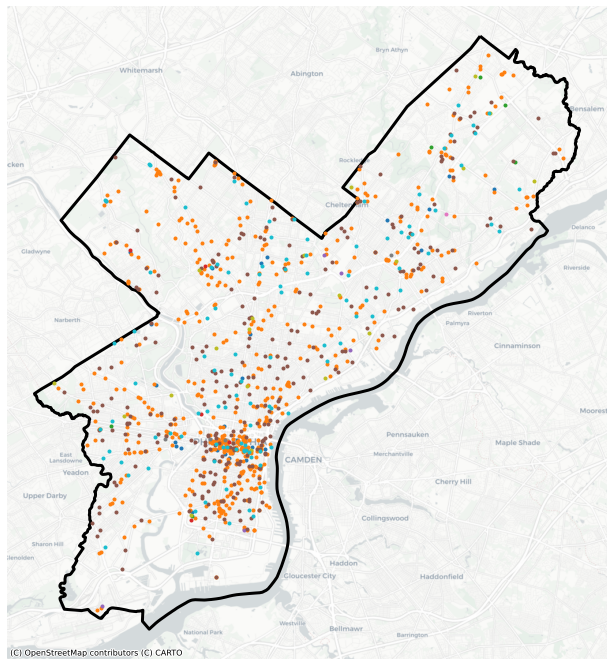

In [38]:

# create the axes
fig, ax = plt.subplots(figsize=(12, 12))

# add the city limits
city_limits.to_crs(clusters.crs).plot(ax=ax, edgecolor='black', linewidth=3, facecolor='none')

# plot a random sample of potholes
groups = clusters.sample(1000).groupby('cluster')
for name, group in groups:
    group.plot(ax=ax, marker='.')

# NEW: plot the basemap underneath
ctx.add_basemap(ax=ax, crs=clusters.crs, url=ctx.providers.CartoDB.Positron)

# remove axis lines
ax.set_axis_off()